**DEEPFAKE DETECTION**

Import the required libraries

In [24]:
import cv2
import torch
import timm
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
from PIL import Image
import numpy as np

Load Face Detection and Deepfake model

In [28]:
mtcnn = MTCNN(keep_all=True, device='cpu')
model = timm.create_model("legacy_xception", pretrained=True, num_classes=1)
model.eval()

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

Data preprocessing

In [29]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

def predict_deepfake(face_img, model):
    face_tensor = transform(face_img).unsqueeze(0)

    with torch.no_grad():
        output = model(face_tensor)
        prediction = torch.sigmoid(output).item()

    label = "Deepfake" if prediction > 0.5 else "Original"
    return label

Model prediction

In [30]:
def process_video(video_path, model):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps)

    frame_count = 0
    elapsed_time = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            boxes, _ = mtcnn.detect(img_rgb)

            if boxes is not None and len(boxes) > 0:
                for box in boxes:
                    x1, y1, x2, y2 = map(int, box)
                    face = img_rgb[y1:y2, x1:x2]
                    face_pil = Image.fromarray(face).resize((299, 299))

                    label = predict_deepfake(face_pil, model)

                    minutes = elapsed_time // 60
                    seconds = elapsed_time % 60
                    time_label = f"Frame: {minutes:02d}:{seconds:02d}"

                    plt.figure(figsize=(4, 4))
                    plt.imshow(face_pil)
                    plt.axis("off")
                    plt.title(f"{time_label}\nPrediction: {label}", fontsize=12)
                    plt.show()

            elapsed_time += 1

        frame_count += 1

    cap.release()

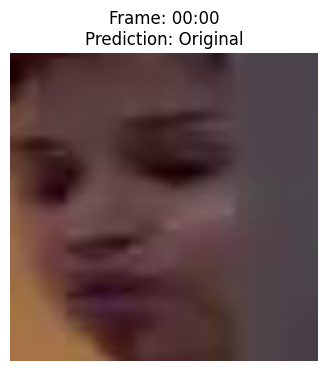

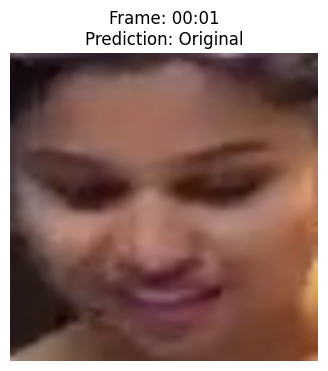

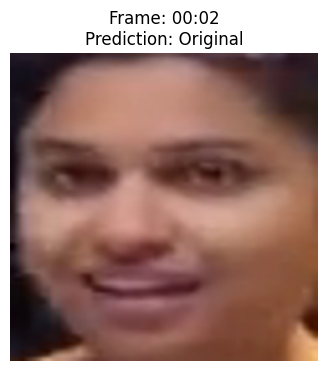

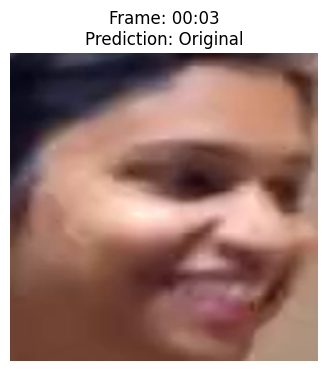

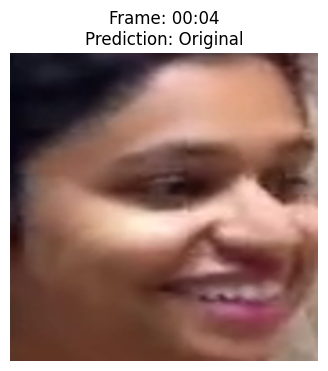

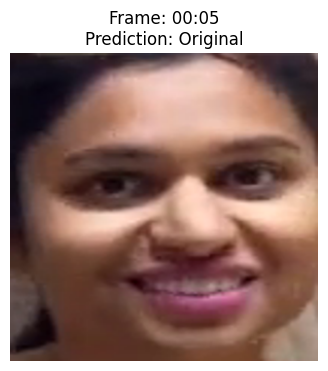

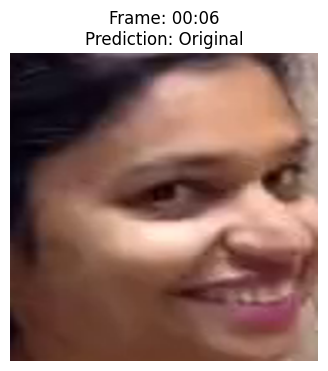

In [22]:
video_path = "/content/original.mp4"
process_video(video_path, model)

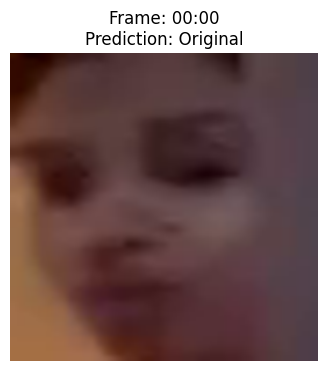

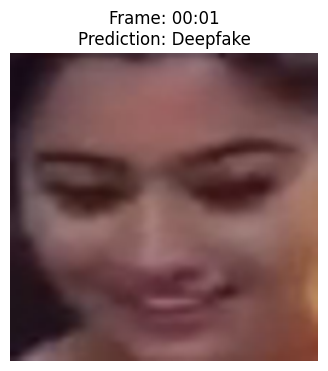

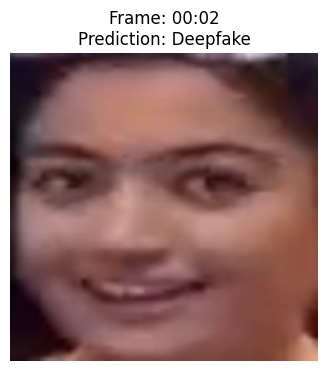

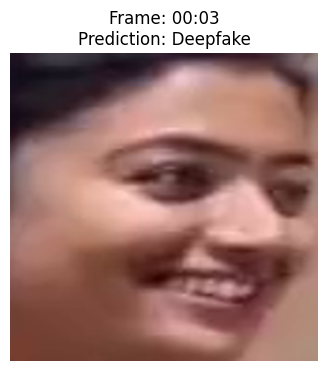

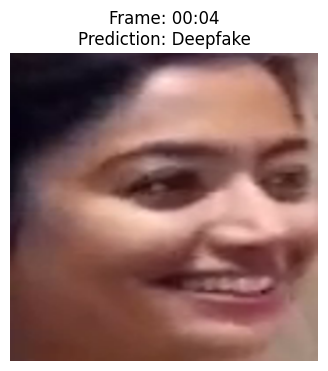

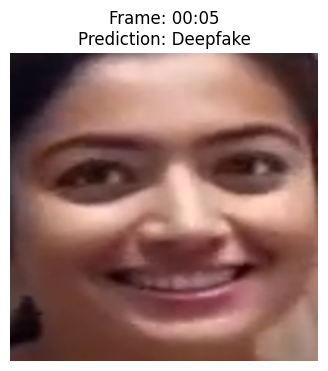

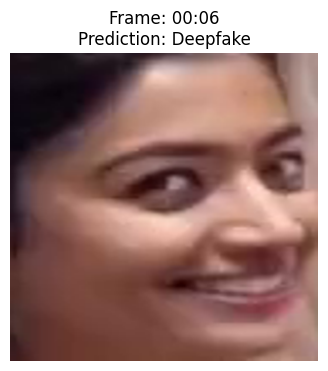

In [7]:
video_path = "/content/deepfake.mp4"
process_video(video_path, model)